In [42]:
import glob
import itertools
import json
import os
import re

import dateutil.parser
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, TransportError
from elasticsearch.helpers import bulk

In [43]:
YEAR = 2009
PATH = 'F:\\saos\\data\\json\\judgments-*'
FILENAMES_FOR_YEAR = f'judgments_from_{YEAR}.json'
ELASTICSEARCH_HOST = 'localhost:9200'
QUERY_WORD = 'szkoda'
QUERY_PHRASE = 'trwały uszczerbek na zdrowiu'
DOC_TYPE = 'doc'

In [44]:
year_pattern = str(YEAR) + '-\d{2}-\d{2}'


def get_filenames_with_judgments_for_year(judgment_filenames):
    with open(FILENAMES_FOR_YEAR, 'w') as file:
        filenames_for_year = filter(contains_judgments_from_year, judgment_filenames)
        json.dump(list(filenames_for_year), file)


def contains_judgments_from_year(filename):
    return any(re.match(year_pattern, item['judgmentDate']) for item in get_judgments(filename))


def get_judgments(filename):
    with open(filename, encoding='utf-8') as file:
        content = json.load(file)
    return (item for item in content['items'] if re.match(year_pattern, item['judgmentDate']))

In [45]:
def create_index(client, index_name):
    analyzer_name = 'polish_analyzer'
    analyzer = {
        analyzer_name: {
            'type': 'custom',
            'tokenizer': 'standard',
            'filter': ['morfologik_stem']
        }
    }
    create_index_body = {
        'settings': {
            'analysis': {
                'analyzer': analyzer
            }
        },
        'mappings': {
            DOC_TYPE: {
                'properties': {
                    'judgment_text': {'type': 'text', 'analyzer': analyzer_name},
                    'judgment_date': {'type': 'date'},
                    'case_number': {'type': 'keyword'},
                    'judges': {'type': 'keyword'}
                }
            }
        }
    }
    try:
        client.indices.create(
            index=index_name,
            body=create_index_body,
        )
    except TransportError as e:
        # ignore already existing index
        if e.error == 'index_already_exists_exception':
            pass
        else:
            raise


def create_actions(judgments):
    for judgment in judgments:
        yield {
            'judgment_text': judgment['textContent'],
            'judgment_date': judgment['judgmentDate'],
            'case_number': [court_case['caseNumber'] for court_case in judgment['courtCases']],
            'judges': [judge['name'] for judge in judgment['judges']]
        }


def bulk_load(client, index_name, judgments):
    result = bulk(client, create_actions(judgments), index=index_name, doc_type=DOC_TYPE)
    print(result)

In [46]:
judgment_filenames = glob.glob(PATH)

if not os.path.isfile(FILENAMES_FOR_YEAR):
    get_filenames_with_judgments_for_year(judgment_filenames)

with open(FILENAMES_FOR_YEAR) as file:
    filenames_with_judgments_for_year = json.load(file)
    judgments = itertools.chain.from_iterable(map(get_judgments, filenames_with_judgments_for_year))

In [47]:
elastic = Elasticsearch(ELASTICSEARCH_HOST)
index_name = 'judgments'

In [48]:
# create_index(elastic, index_name)
# bulk_load(elastic, index_name, judgments)
# elastic.indices.delete(index=index_name, ignore=[400, 404])

In [49]:
print(f'Liczba orzeczeń, w których występuje słowo "{QUERY_WORD}"')
elastic.search(index_name, DOC_TYPE, {'query': {'match': {'judgment_text': QUERY_WORD}}})['hits']['total']

Liczba orzeczeń, w których występuje słowo "szkoda"


733

In [50]:
print(f'Liczba orzeczeń, w których występuje fraza "{QUERY_PHRASE}" w dowolnej formie fleksyjnej')
res = elastic.search(index_name, DOC_TYPE, {'query': {'match_phrase': {'judgment_text': QUERY_PHRASE}}})
res['hits']['total']

Liczba orzeczeń, w których występuje fraza "trwały uszczerbek na zdrowiu" w dowolnej formie fleksyjnej


6

In [51]:
print(f'''Liczba orzeczeń, w których występuje fraza "{QUERY_PHRASE}" w dowolnej formie fleksyjnej z 
uwzględnieniem możliwości wystąpienia maksymalnie 2 dodatkowych słów pomiędzy dowolnymi elementami frazy''')
query = {
    'query': {'match_phrase': {'judgment_text': {'query': QUERY_PHRASE, 'slop': 2}}}
}
res2 = elastic.search(index_name, DOC_TYPE, query)
res2['hits']['total']

Liczba orzeczeń, w których występuje fraza "trwały uszczerbek na zdrowiu" w dowolnej formie fleksyjnej z 
uwzględnieniem możliwości wystąpienia maksymalnie 2 dodatkowych słów pomiędzy dowolnymi elementami frazy


7

In [52]:
agg_query = {
    'size': 0,
    'aggregations': {
        'judges': {
            'terms': {
                'field': 'judges'
            }
        }
    }
}
judges = elastic.search(index_name, DOC_TYPE, agg_query)['aggregations']['judges']['buckets']  # sorted by doc_count desc by default
print(f'Sędziowie z największą liczbą orzeczeń wydanych w roku {YEAR}')
for judge in judges[:3]:
    print(judge['key'], '->', judge['doc_count'])

Sędziowie z największą liczbą orzeczeń wydanych w roku 2009
Andrzej Niwicki -> 234
Sylwester Kuchnio -> 225
Barbara Bettman -> 221


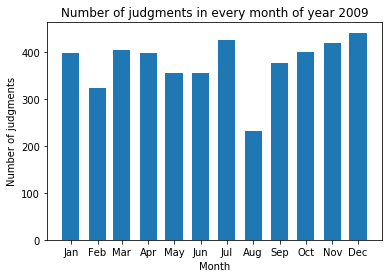

In [53]:
month_agg = {
    'size': 0,
    'aggs': {
        'months': {
            'date_histogram': {
                'field': 'judgment_date',
                'interval': 'month'
            }
        }
    }
}
months_agg_result = elastic.search(index_name, DOC_TYPE, month_agg)['aggregations']['months']['buckets']
counts = [item['doc_count'] for item in months_agg_result]
dates = [dateutil.parser.parse(item['key_as_string']) for item in months_agg_result]
months = [date.strftime('%b') for date in dates]
plt.bar(dates, counts, width=20, tick_label=months)
plt.xlabel('Month')
plt.ylabel('Number of judgments')
plt.title(f'Number of judgments in every month of year {YEAR}')
plt.savefig('histogram.png')
plt.show()

In [54]:
for date, count in zip(months, counts):
    print(date, '->', count)

Jan -> 398
Feb -> 325
Mar -> 405
Apr -> 399
May -> 357
Jun -> 355
Jul -> 426
Aug -> 232
Sep -> 377
Oct -> 401
Nov -> 420
Dec -> 442
